# Import Modules

In [1]:
import os
import random
import pickle
import importlib
import argparse

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [2]:
import config
import model
import utility

# Set Random Seed

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

# Testing

In [6]:
configs = config.configs

#load data
binance_swaps = pd.read_csv(os.path.join("data", "binance_swaps.csv"), index_col=0)
binance_swaps_return = (binance_swaps/binance_swaps.shift(1) - 1)[1:]
binance_swaps_return.index = pd.to_datetime(binance_swaps_return.index)
with open(os.path.join("data", "weekly_crypto_top20.pkl"), 'rb') as f:
    weekly_crypto_top20 = pickle.load(f)

#Prepare training, validation, and testing periods and tickers for each week.
stables = {"BUSD", "USDC", "UST", "DAI", "TUSD", "USDT"}
cexs = {"FTT", "BNB", "HT", "OKB", "CRO", "LEO"}
not_listed = {"WBTC", "TON"}
name_changed = {"SHIB": "1000SHIB"}
remove = stables | cexs | not_listed
setting_list = []

for k, v in weekly_crypto_top20.items():
    valid_tickers = set(v) - remove
    t = pd.to_datetime(k) + pd.Timedelta("1min")
    if t <= pd.to_datetime("2023-01-01"):
        continue
        
    listed = list(binance_swaps_return.loc[t].dropna().index) # Check whether a swap is listed on Binance at the start of the week.
    
    valid_tickers_top10 = []
    for ticker in v:
        if ticker in valid_tickers and ticker in listed:
            if ticker in name_changed.keys():
                valid_tickers_top10.append(name_changed[ticker])
            else:
                valid_tickers_top10.append(ticker)
    valid_tickers_top10 = valid_tickers_top10[:10]

    testing_period = (t, t +  pd.Timedelta("10079min"))
    validation_period = (t - pd.Timedelta("10080min"), t - pd.Timedelta("1min"))
    training_period = (t - pd.Timedelta("40320min"), t - pd.Timedelta("10081min"))
    
    setting_list.append([training_period, validation_period, testing_period, valid_tickers_top10])

In [21]:
tcn_result_dir = r"result\TCN_2023-12-15_23-45-27"
MPT_result_dir = r"result\MPT_2023-12-15_23-42-52"
RP_result_dir = r"result\RP_2023-12-15_23-07-40"

In [22]:
input_length = configs["portfolio_config"]["input_length"]
input_td = pd.Timedelta(f"{input_length}min")
testing_return_series_tcn = pd.Series()
testing_return_series_mpt = pd.Series()
testing_return_series_rp = pd.Series()

for setting in setting_list:
    #Prepare data for each week
    training_period, validation_period, testing_period, tickers = setting
    training_return = binance_swaps_return[tickers].loc[training_period[0]-input_td:training_period[1]].fillna(0)
    validation_return = binance_swaps_return[tickers].loc[validation_period[0]-input_td:validation_period[1]].fillna(0)
    testing_return = binance_swaps_return[tickers].loc[testing_period[0]-input_td:testing_period[1]].fillna(0)
    data_list = [training_return, validation_return]

    tcn_model_dir = os.path.join(tcn_result_dir, testing_period[0].isoformat().replace(":", "") + "_" + testing_period[1].isoformat().replace(":", ""), "TCN_best_set_params.pth")
    mpt_dir = os.path.join(MPT_result_dir, testing_period[0].isoformat().replace(":", "") + "_" + testing_period[1].isoformat().replace(":", ""), "training_result.pkl")
    #rp_dir = os.path.join(RP_result_dir, testing_period[0].isoformat().replace(":", "") + "_" + testing_period[1].isoformat().replace(":", ""), "training_result.pkl")

    nn_model = model.NNModel(data_list, configs, "TCN")
    weight_tcn = nn_model.predict_weight(testing_return, tcn_model_dir)
    
    with open(mpt_dir, "rb") as input_file:
        mpt_weight = pickle.load(input_file)

    #with open(rp_dir, "rb") as input_file:
    #    rp_weight = pickle.load(input_file)
    
    testing_return_tcn = (weight_tcn*testing_return.iloc[input_length:]).sum(axis=1)
    testing_return_series_tcn = pd.concat([testing_return_series_tcn, testing_return_tcn])

    testing_return_mpt = testing_return.mul(mpt_weight).sum(axis=1)
    testing_return_series_mpt = pd.concat([testing_return_series_mpt, testing_return_mpt])
    
    #testing_return_rp = testing_return.mul(rp_weight).sum(axis=1)
    #testing_return_series_rp = pd.concat([testing_return_series_rp, testing_return_rp])

C:\Users\andy8\AppData\Local\Temp\ipykernel_12556\422942724.py:29: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  testing_return_series_tcn = pd.concat([testing_return_series_tcn, testing_return_tcn])
C:\Users\andy8\AppData\Local\Temp\ipykernel_12556\422942724.py:32: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  testing_return_series_mpt = pd.concat([testing_return_series_mpt, testing_return_mpt])


In [23]:
testing_return_series_tcn.mean() / testing_return_series_tcn.std()

0.002051719843903289

In [24]:
testing_return_series_mpt.mean() / testing_return_series_mpt.std()

4.052447858690029e-05

In [11]:
testing_return_series_rp.mean() / testing_return_series_rp.std()

0.002188042249756712

<Axes: >

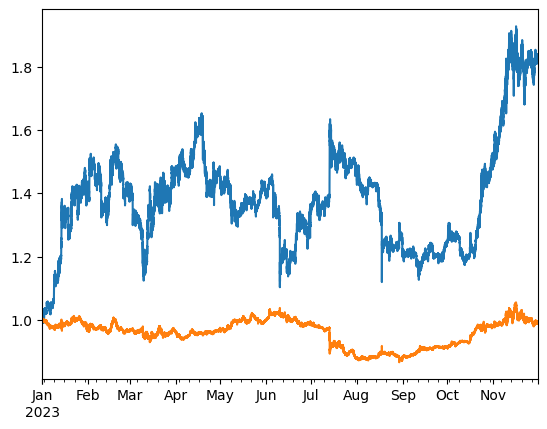

In [25]:
testing_return_series_tcn.add(1).cumprod().plot()
testing_return_series_mpt.add(1).cumprod().plot()